In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.color_palette("husl", 10)
import missingno as msno

from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import DataConversionWarning
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
from warnings import filterwarnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from fractions import Fraction
from string import ascii_letters

def frac_to_float(frac):
    try:
        if isinstance(frac, float):
            return frac
        if frac == "1 / 200s":
            frac = "1/200"
        return float(sum(Fraction(s.rstrip(ascii_letters)) for s in frac.split()))
    except:
        print(frac)

def show_perc_values_missing(df):
    ncounts = pd.DataFrame([df.isna().mean()]).T
    ncounts = ncounts.rename(columns={0: "train_missing"})

    ncounts.query("train_missing > 0").plot(
        kind="barh", figsize=(8, 15), title="% of Values Missing"
    )
    plt.show()

In [229]:
train = pd.read_csv("data/train.csv")
train_colors = pd.read_csv("data/train_colors.csv")
train_keywords = pd.read_csv("data/train_keywords.csv")
test = pd.read_csv("data/test.csv")
test_colors = pd.read_csv("data/test_colors.csv")
test_keywords = pd.read_csv("data/test_keywords.csv")

outlier_ids = train[train["stats_downloads"] > 450000]["image_id"]

In [231]:
test_keywords

,image_id,image_classification,classification_keyword,confidence_value
0,15042b5f5d,Predicted,worship,24.516
1,15042b5f5d,Predicted,cave,31.372
2,15042b5f5d,Predicted,waterfront,21.537
3,15042b5f5d,Predicted,flare,50.113
4,15042b5f5d,Predicted,hole,15.343
...,...,...,...,...
693738,40e663e567,Predicted,archangel,28.522
693739,40e663e567,Predicted,cricket insect,35.448
693740,40e663e567,Predicted,plush,28.582
693741,40e663e567,Predicted,sleeping,33.188


In [232]:
test[test["image_id"] == "15042b5f5d"]

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days
618,15042b5f5d,https://unsplash.com/photos/zz1F6I1qlVk,https://images.unsplash.com/photo-157501564155...,2019-11-29 08:21:47.748376,Friday,8,21,47,Featured,3803,5704,0.670,moeraki boulders,black rock formation,FUJIFILM,X-T20,100.000,1.000,50.000,30,NaN,NaN,NaN,NaN,1198


In [83]:
def get_summary_df(df: pd.DataFrame, column: str):
    value = []
    counts = []
    avg_downloads = []
    for group, data in df.groupby(column):
        value.append(group)
        counts.append(len(data))
        avg_downloads.append(data["stats_downloads"].mean())
    value_df = pd.DataFrame({"value": value, "count": counts, "avg_downloads": avg_downloads})
    return value_df

In [97]:
train_country = train[~train["country"].isna()]
# train_country.isnull().sum()
country_df = get_summary_df(train_country, "country")
country_df.sort_values(["avg_downloads", "count"], ascending=False, inplace=True)
country_df.reset_index(drop=True, inplace=True)
country_df[country_df["count"] > 20]
# country_df[country_df["count"] > 20]["avg_downloads"].median()

,value,count,avg_downloads
14,Japan,24,36717.542
16,Maldives,30,33101.233
24,Norway,38,27346.947
28,Greece,31,24050.806
34,Spain,47,20623.532
37,New Zealand,68,19668.529
43,Romania,32,17212.312
44,Italy,178,17146.011
49,Mexico,27,16047.185
51,Russia,30,15950.867


<Axes: xlabel='avg_downloads', ylabel='Count'>

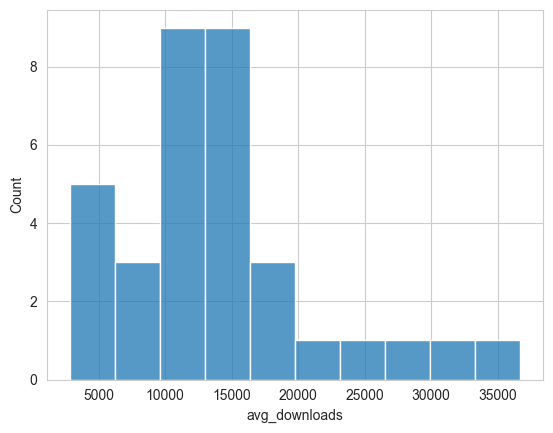

In [94]:
sns.histplot(country_df[country_df["count"] > 20].avg_downloads)

In [8]:
train_downloads = train[["image_id", "stats_downloads"]]
colors_labeled = train_colors.merge(train_downloads, how="inner", on="image_id")
colors_labeled = colors_labeled[~colors_labeled["image_id"].isin(outlier_ids)]
words_labeled = train_keywords.merge(train_downloads, how="inner", on="image_id")
words_labeled = words_labeled[~words_labeled["image_id"].isin(outlier_ids)]
colors_labeled

,image_id,R,G,B,image_hex,keyword,pixel_coverage,color_score,stats_downloads
0,34d72beca9,69,112,154,45709A,steelblue,0.130,0.093,3082
1,34d72beca9,184,185,185,B8B9B9,silver,0.052,0.111,3082
2,34d72beca9,122,122,123,7A7A7B,gray,0.124,0.071,3082
3,34d72beca9,54,95,136,365F88,darkslateblue,0.035,0.069,3082
4,34d72beca9,172,188,206,ACBCCE,lightsteelblue,0.004,0.021,3082
...,...,...,...,...,...,...,...,...,...
119886,e7fd9086d1,80,81,88,505158,darkslategray,0.004,0.004,12353
119887,e7fd9086d1,51,52,67,333443,darkslategray,0.004,0.004,12353
119888,e7fd9086d1,109,111,119,6D6F77,dimgray,0.000,0.000,12353
119889,e7fd9086d1,36,34,40,242228,darkslategray,0.000,0.000,12353


In [9]:
words_labeled

,image_id,image_classification,classification_keyword,confidence_value,stats_downloads
0,d0d041755d,Predicted,grove,99.077,1320
1,d0d041755d,Predicted,compass,26.864,1320
2,d0d041755d,Predicted,field,94.294,1320
3,d0d041755d,Predicted,jar,43.129,1320
4,d0d041755d,Predicted,flower,81.635,1320
...,...,...,...,...,...
1291027,8aa2cc9225,Predicted,hotel,33.519,1215
1291028,8aa2cc9225,Predicted,resort,28.783,1215
1291029,8aa2cc9225,Predicted,light,52.601,1215
1291030,8aa2cc9225,Predicted,light fixture,33.200,1215


In [10]:
colors = []
counts = []
avg_downloads = []
for group, data in colors_labeled.groupby("keyword"):
    colors.append(group)
    counts.append(len(data))
    avg_downloads.append(data["stats_downloads"].mean())
color_downloads = pd.DataFrame({"color": colors, "count": counts, "avg_downloads": avg_downloads})

In [202]:
len(color_downloads)

139

<Axes: xlabel='avg_downloads', ylabel='Count'>

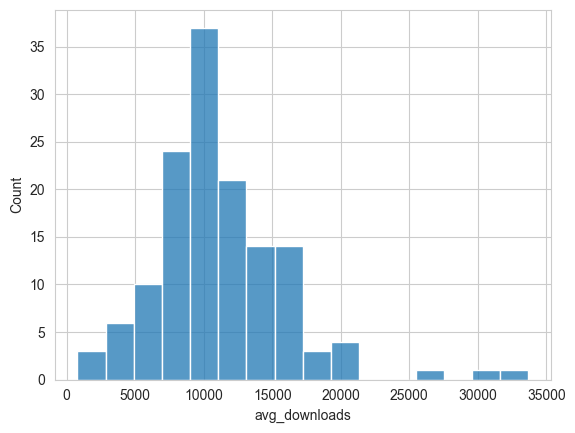

In [133]:
sns.histplot(color_downloads["avg_downloads"])
# color_downloads["avg_downloads"].median()

In [207]:
color_downloads.sort_values(["count", "avg_downloads"], ascending=False, inplace=True)
color_downloads.reset_index(drop=True, inplace=True)
cd = color_downloads[color_downloads["count"] > 100]
cd

,color,count,avg_downloads
0,darkslategray,17879,9164.268
1,dimgray,10155,8595.077
2,darkolivegreen,8627,8066.791
3,black,7944,7711.406
4,gray,7000,8248.765
...,...,...,...
72,mediumpurple,121,9676.066
73,peachpuff,120,10872.142
74,forestgreen,118,14877.415
75,rebeccapurple,116,12415.164


In [136]:
high_colors = color_downloads[(color_downloads["count"] > 500) & (color_downloads["avg_downloads"] > 11000)].color
high_colors

13    lightsteelblue
16         darkkhaki
19         cadetblue
20         steelblue
21          lavender
22         indianred
24     darkslateblue
25      midnightblue
28              teal
30      darkseagreen
31             brown
32         goldenrod
Name: color, dtype: object

In [137]:
color_importance = []
for i, image_id in enumerate(train["image_id"]):
    if i % 100 == 0:
        print(i)
    colors = train_colors[train_colors["image_id"] == image_id]
    num_high_colors = len(colors[colors["keyword"].isin(high_colors)])
    color_importance.append(num_high_colors)
color_importance

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100


[2,
 1,
 1,
 0,
 6,
 2,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 1,
 0,
 0,
 5,
 1,
 1,
 1,
 2,
 0,
 6,
 0,
 0,
 0,
 3,
 1,
 0,
 4,
 0,
 2,
 0,
 1,
 3,
 1,
 0,
 1,
 0,
 5,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 6,
 1,
 0,
 1,
 0,
 1,
 5,
 2,
 1,
 0,
 3,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 2,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 3,
 2,
 1,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 2,
 2,
 4,
 1,
 2,
 0,
 0,
 4,
 2,
 0,
 1,
 0,
 6,
 0,
 3,
 2,
 0,
 0,
 2,
 1,
 0,
 0,
 1,
 0,
 0,
 5,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 2,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 3,
 0,
 0,
 1,
 3,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 1,
 3,
 0,
 4,
 2,
 0,
 3,
 0,
 1,
 5,
 0,
 2,
 1,
 2,
 4,
 3,
 1,
 3,
 0,
 1,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 6,
 7,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 3,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 2,
 3,
 3,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 4,
 2,
 0,
 4,
 3,
 3,
 0,
 0,
 0,
 0,
 4,
 2,
 0,
 0,
 5,
 0,
 1,


In [138]:
train["high_color_count"] = color_importance
train

,image_id,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,stats_downloads,high_word_count,high_color_count
0,68105c019b,Thursday,15,13,10,1,2592,1728,1.500,Pristine water lily,rule of thirds photography of pink and white l...,canon,Canon EOS 60D,200.000,14.000,50.000,0.017,2361,167503,5,2
1,06d11c4edd,Wednesday,21,59,51,1,4000,6000,0.670,NaN,sand in desert,sony,ILCE-6500,100.000,2.500,30.000,0.001,1255,1839,9,1
2,f6599edba1,Tuesday,4,10,11,1,5504,8256,0.670,NaN,green trees near brown mountain during daytime,nikon,NIKON D850,64.000,2.800,48.000,0.001,1138,787,14,1
3,0f4bcc2d36,Monday,23,46,21,1,3627,2040,1.780,NaN,gray dock aerial photography,dji,FC220,139.000,2.200,4.700,0.010,1579,2049,19,0
4,74db502ed5,Saturday,11,4,20,1,4896,3264,1.500,NaN,people walking on green grass field near lake ...,fujifilm,X-T10,400.000,6.400,22.200,0.002,1050,2982,21,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12123,18eaca644e,Monday,13,7,25,1,4480,6111,0.730,NaN,calm water during night time,canon,Canon EOS 5D Mark IV,100.000,5.600,300.000,0.003,1265,2353,24,3
12124,eb25cd769e,Monday,20,32,28,1,2403,3337,0.720,NaN,snowflakes on ground,canon,Canon EOS 5D Mark III,400.000,5.000,100.000,0.003,1503,3541,2,0
12125,73302461d0,Thursday,1,54,16,1,5184,3456,1.500,Inside of the small wave,NaN,canon,Canon EOS M,400.000,4.000,21.000,0.000,2501,14581,14,3
12126,f2587b2b08,Thursday,18,2,32,1,6000,4000,1.500,Tropical palm,low angle of banana tree,nikon,NIKON D5300,800.000,1.800,50.000,0.003,2508,9247,11,2


In [139]:
train.to_csv("data/train_with_high_word_color.csv", index=False)

In [228]:
np.average(cd.avg_downloads, weights=cd["count"])

9482.684745158607

In [208]:
color_w_imp = []
for i, image_id in enumerate(train["image_id"]):
    if i % 500 == 0:
        print(i)
    im_colors = train_colors[train_colors["image_id"] == image_id]
    color_df = im_colors[im_colors["keyword"].isin(cd["color"])]
    if len(color_df) == 0:
        download_val = 9521.05732984512
    # There are keywords of interest
    else:
        color_df = pd.merge(color_df, cd, left_on="keyword", right_on="color", how="inner")
        download_val = np.average(color_df["avg_downloads"], weights=color_df["count"])
    color_w_imp.append(download_val)
color_w_imp

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000


[8907.599471201944,
 9238.795354542268,
 8700.846935613807,
 8754.852234354874,
 10344.244743935309,
 9598.557339835212,
 8913.543207175673,
 8995.493982273014,
 8614.364158748827,
 8816.546534175699,
 8637.088832002446,
 8790.401516046644,
 8742.021019831978,
 8604.765529808528,
 8784.403609923931,
 8661.29479768786,
 9704.790398857856,
 8428.485060438916,
 8557.831740319227,
 8730.703380588877,
 8968.33320119244,
 8884.798386025504,
 10628.694905124757,
 8905.053993221058,
 7864.786894509178,
 8682.212121573444,
 9044.436394895027,
 8519.897478107392,
 8459.315996431285,
 9428.235673818148,
 8452.830913470929,
 10020.085069836821,
 8462.006617051286,
 8411.936851255305,
 9354.290739424767,
 9018.103553371786,
 8738.670250457159,
 8708.307475317348,
 8841.366193740758,
 10846.281228914579,
 8458.760293495901,
 8808.800819948332,
 8467.9468321113,
 8631.115398785782,
 8607.523822502342,
 9231.20900661742,
 8817.050071949272,
 8742.021019831978,
 8586.112548793615,
 8572.673788894283,
 

In [209]:
train["high_weighted_color_count"] = color_w_imp
train.to_csv("data/train_with_weights.csv", index=False)
train

,image_id,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,stats_downloads,high_word_count,high_color_count,high_weighted_word_count,high_weighted_color_count
0,68105c019b,Thursday,15,13,10,1,2592,1728,1.500,Pristine water lily,rule of thirds photography of pink and white l...,canon,Canon EOS 60D,200.000,14.000,50.000,0.017,2361,167503,5,2,8832.250,8907.599
1,06d11c4edd,Wednesday,21,59,51,1,4000,6000,0.670,NaN,sand in desert,sony,ILCE-6500,100.000,2.500,30.000,0.001,1255,1839,9,1,6191.692,9238.795
2,f6599edba1,Tuesday,4,10,11,1,5504,8256,0.670,NaN,green trees near brown mountain during daytime,nikon,NIKON D850,64.000,2.800,48.000,0.001,1138,787,14,1,6538.208,8700.847
3,0f4bcc2d36,Monday,23,46,21,1,3627,2040,1.780,NaN,gray dock aerial photography,dji,FC220,139.000,2.200,4.700,0.010,1579,2049,19,0,6583.103,8754.852
4,74db502ed5,Saturday,11,4,20,1,4896,3264,1.500,NaN,people walking on green grass field near lake ...,fujifilm,X-T10,400.000,6.400,22.200,0.002,1050,2982,21,6,6933.680,10344.245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12123,18eaca644e,Monday,13,7,25,1,4480,6111,0.730,NaN,calm water during night time,canon,Canon EOS 5D Mark IV,100.000,5.600,300.000,0.003,1265,2353,24,3,7111.747,8840.593
12124,eb25cd769e,Monday,20,32,28,1,2403,3337,0.720,NaN,snowflakes on ground,canon,Canon EOS 5D Mark III,400.000,5.000,100.000,0.003,1503,3541,2,0,5829.021,8083.211
12125,73302461d0,Thursday,1,54,16,1,5184,3456,1.500,Inside of the small wave,NaN,canon,Canon EOS M,400.000,4.000,21.000,0.000,2501,14581,14,3,9575.381,13116.181
12126,f2587b2b08,Thursday,18,2,32,1,6000,4000,1.500,Tropical palm,low angle of banana tree,nikon,NIKON D5300,800.000,1.800,50.000,0.003,2508,9247,11,2,8448.478,8647.285


In [13]:
words = []
counts = []
avg_downloads = []
for group, data in words_labeled.groupby("classification_keyword"):
    words.append(group)
    counts.append(len(data))
    avg_downloads.append(data["stats_downloads"].mean())
word_downloads = pd.DataFrame({"word": words, "count": counts, "avg_downloads": avg_downloads})

In [203]:
len(word_downloads)

18219

In [180]:
# word_downloads.sort_values(["count", "avg_downloads"], ascending=False, inplace=True)
word_downloads.sort_values(["avg_downloads", "count"], ascending=False, inplace=True)
word_downloads.reset_index(drop=True, inplace=True)
# word_downloads[word_downloads["count"] > 1000]
wd = word_downloads[word_downloads["count"] > 100]
wd

,word,count,avg_downloads
771,cool backgrounds,153,58174.765
772,hd backgrounds,155,58122.781
781,computer backgrounds,149,57446.550
782,tumblr backgrounds,149,57446.550
795,hd wallpapers,178,56282.152
...,...,...,...
14835,prison,130,2480.385
14908,bonnet,349,2438.014
15155,zebra crossing,107,2312.178
15224,awning,170,2291.559


In [168]:
np.average(word_downloads.avg_downloads, weights=word_downloads["count"])

6638.149276551139

In [175]:
im_id = train.iloc[0]["image_id"]
im_kws = train_keywords[train_keywords["image_id"] == im_id]
im_kws
kw_df = im_kws[im_kws["classification_keyword"].isin(wd["word"])]

In [181]:
kw_w_imp = []
for i, image_id in enumerate(train["image_id"]):
    if i % 100 == 0:
        print(i)
    im_kws = train_keywords[train_keywords["image_id"] == image_id]
    kw_df = im_kws[im_kws["classification_keyword"].isin(wd["word"])]
    if len(kw_df) == 0:
        download_val = 6638.149276551139
    # There are keywords of interest
    else:
        kw_df = pd.merge(kw_df, wd, left_on="classification_keyword", right_on="word", how="inner")
        download_val = np.average(kw_df["avg_downloads"], weights=kw_df["count"])
    kw_w_imp.append(download_val)
kw_w_imp


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100


[8832.250314733397,
 6191.691848770776,
 6538.207977050326,
 6583.102732693243,
 6933.679792420773,
 6620.5104052134875,
 5751.102392822703,
 6371.251886741182,
 5853.13122431425,
 6595.123452146123,
 6366.0769318168905,
 8236.500920292943,
 6253.698313881145,
 8489.574044095525,
 6292.151574959983,
 6137.3915723874115,
 6800.879261622916,
 8885.266800124253,
 7062.694394084183,
 6014.403981586033,
 7084.840439115798,
 6704.53348782963,
 7987.212283602809,
 6429.406112942072,
 6122.621338528617,
 6090.760050267004,
 6349.863396913054,
 6565.947780385098,
 5836.371234525096,
 7426.577254910795,
 5543.002669379101,
 10302.198388721048,
 5604.577632181023,
 6732.388240185163,
 6726.576254603313,
 6584.239116105966,
 6303.961235776162,
 6159.620107261298,
 6722.321047152595,
 8492.976725485816,
 6451.116903554484,
 6632.7200400224365,
 6615.115280465452,
 6021.164934203873,
 5596.0561505263395,
 9173.353488372093,
 6029.586456426758,
 6685.4967224723405,
 6503.692245030955,
 6298.081717386

In [182]:
train["high_weighted_word_count"] = kw_w_imp
train.to_csv("data/train_with_weight.csv", index=False)
train

,image_id,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,stats_downloads,high_word_count,high_color_count,high_weighted_word_count
0,68105c019b,Thursday,15,13,10,1,2592,1728,1.500,Pristine water lily,rule of thirds photography of pink and white l...,canon,Canon EOS 60D,200.000,14.000,50.000,0.017,2361,167503,5,2,8832.250
1,06d11c4edd,Wednesday,21,59,51,1,4000,6000,0.670,NaN,sand in desert,sony,ILCE-6500,100.000,2.500,30.000,0.001,1255,1839,9,1,6191.692
2,f6599edba1,Tuesday,4,10,11,1,5504,8256,0.670,NaN,green trees near brown mountain during daytime,nikon,NIKON D850,64.000,2.800,48.000,0.001,1138,787,14,1,6538.208
3,0f4bcc2d36,Monday,23,46,21,1,3627,2040,1.780,NaN,gray dock aerial photography,dji,FC220,139.000,2.200,4.700,0.010,1579,2049,19,0,6583.103
4,74db502ed5,Saturday,11,4,20,1,4896,3264,1.500,NaN,people walking on green grass field near lake ...,fujifilm,X-T10,400.000,6.400,22.200,0.002,1050,2982,21,6,6933.680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12123,18eaca644e,Monday,13,7,25,1,4480,6111,0.730,NaN,calm water during night time,canon,Canon EOS 5D Mark IV,100.000,5.600,300.000,0.003,1265,2353,24,3,7111.747
12124,eb25cd769e,Monday,20,32,28,1,2403,3337,0.720,NaN,snowflakes on ground,canon,Canon EOS 5D Mark III,400.000,5.000,100.000,0.003,1503,3541,2,0,5829.021
12125,73302461d0,Thursday,1,54,16,1,5184,3456,1.500,Inside of the small wave,NaN,canon,Canon EOS M,400.000,4.000,21.000,0.000,2501,14581,14,3,9575.381
12126,f2587b2b08,Thursday,18,2,32,1,6000,4000,1.500,Tropical palm,low angle of banana tree,nikon,NIKON D5300,800.000,1.800,50.000,0.003,2508,9247,11,2,8448.478


In [ ]:
# Create new column, fill with 6638.149276551139 if no words match the word list, else set value to be weighted average of words associated with image
im_id = train.iloc[0]["image_id"]
im_kws = train_keywords[train_keywords["image_id"] == im_id]
kw_df = im_kws[im_kws["classification_keyword"].isin(wd["word"])]
if len(kw_df) == 0:
    download_val = 6638.149276551139
# There are keywords of interest
else:
    kw_df = pd.merge(kw_df, wd, left_on="classification_keyword", right_on="word", how="inner")
    # download_val = np.average
kw_df
np.average(kw_df["avg_downloads"], weights=kw_df["count"])

In [67]:
high_words  = word_downloads[(word_downloads["count"] > 1000) & (word_downloads["avg_downloads"] > 8000)].word
len(high_words)

42

In [68]:
word_importance = []
for i, row in train.iterrows():
    if i % 100 == 0:
        print(i)
    words = train_keywords[train_keywords["image_id"] == row["image_id"]]
    num_high_words = len(words[words["classification_keyword"].isin(high_words)])
    word_importance.append(num_high_words)
word_importance

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100


[5,
 9,
 14,
 19,
 21,
 22,
 5,
 9,
 2,
 19,
 3,
 9,
 9,
 6,
 6,
 10,
 20,
 5,
 23,
 5,
 22,
 16,
 12,
 9,
 7,
 7,
 11,
 16,
 4,
 4,
 0,
 20,
 1,
 10,
 17,
 15,
 8,
 5,
 18,
 5,
 13,
 15,
 16,
 3,
 2,
 7,
 4,
 15,
 14,
 9,
 19,
 19,
 11,
 1,
 9,
 3,
 16,
 10,
 0,
 3,
 23,
 14,
 9,
 14,
 0,
 1,
 19,
 15,
 3,
 12,
 4,
 7,
 17,
 8,
 21,
 6,
 21,
 2,
 4,
 1,
 8,
 4,
 14,
 4,
 1,
 11,
 9,
 2,
 4,
 6,
 0,
 10,
 9,
 3,
 11,
 26,
 19,
 14,
 13,
 14,
 5,
 16,
 4,
 6,
 22,
 13,
 4,
 7,
 22,
 1,
 0,
 9,
 2,
 7,
 14,
 1,
 16,
 7,
 3,
 9,
 21,
 15,
 10,
 14,
 15,
 7,
 9,
 7,
 1,
 17,
 17,
 20,
 17,
 17,
 5,
 3,
 1,
 4,
 21,
 13,
 15,
 0,
 6,
 14,
 14,
 9,
 15,
 6,
 23,
 2,
 13,
 0,
 7,
 22,
 20,
 2,
 4,
 9,
 3,
 20,
 3,
 9,
 6,
 0,
 25,
 4,
 3,
 22,
 6,
 15,
 4,
 0,
 11,
 14,
 4,
 13,
 1,
 22,
 18,
 26,
 13,
 3,
 10,
 26,
 0,
 4,
 19,
 7,
 4,
 12,
 11,
 5,
 15,
 6,
 20,
 1,
 10,
 9,
 17,
 7,
 21,
 6,
 14,
 15,
 12,
 14,
 4,
 5,
 6,
 1,
 6,
 0,
 20,
 13,
 7,
 17,
 15,
 20,
 13,
 2,
 16,
 17,
 4,
 5,

In [69]:
train["high_word_count"] = word_importance
train

,image_id,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,stats_downloads,high_word_count
0,68105c019b,Thursday,15,13,10,1,2592,1728,1.500,Pristine water lily,rule of thirds photography of pink and white l...,canon,Canon EOS 60D,200.000,14.000,50.000,0.017,2361,167503,5
1,06d11c4edd,Wednesday,21,59,51,1,4000,6000,0.670,NaN,sand in desert,sony,ILCE-6500,100.000,2.500,30.000,0.001,1255,1839,9
2,f6599edba1,Tuesday,4,10,11,1,5504,8256,0.670,NaN,green trees near brown mountain during daytime,nikon,NIKON D850,64.000,2.800,48.000,0.001,1138,787,14
3,0f4bcc2d36,Monday,23,46,21,1,3627,2040,1.780,NaN,gray dock aerial photography,dji,FC220,139.000,2.200,4.700,0.010,1579,2049,19
4,74db502ed5,Saturday,11,4,20,1,4896,3264,1.500,NaN,people walking on green grass field near lake ...,fujifilm,X-T10,400.000,6.400,22.200,0.002,1050,2982,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12192,18eaca644e,Monday,13,7,25,1,4480,6111,0.730,NaN,calm water during night time,canon,Canon EOS 5D Mark IV,100.000,5.600,300.000,0.003,1265,2353,24
12193,eb25cd769e,Monday,20,32,28,1,2403,3337,0.720,NaN,snowflakes on ground,canon,Canon EOS 5D Mark III,400.000,5.000,100.000,0.003,1503,3541,2
12194,73302461d0,Thursday,1,54,16,1,5184,3456,1.500,Inside of the small wave,NaN,canon,Canon EOS M,400.000,4.000,21.000,0.000,2501,14581,14
12195,f2587b2b08,Thursday,18,2,32,1,6000,4000,1.500,Tropical palm,low angle of banana tree,nikon,NIKON D5300,800.000,1.800,50.000,0.003,2508,9247,11


In [70]:
train.to_csv("data/train_with_hwc8000.csv", index=False)

In [48]:
def get_num_high_words(image_id):
    words = train_keywords[train_keywords["image_id"] == image_id]
    num_high_words = len(words[words["classification_keyword"].isin(high_words)])
    word_importance.append(num_high_words)

def test_apply(a):
    return 1

In [ ]:
train_keywords[train_keywords[image_id] == '68105c019b']

In [100]:
# train["image_id"].apply(get_num_high_words)

In [24]:
word_downloads[(word_downloads["count"] > 1000) & (word_downloads["avg_downloads"] < 4500)]

,word,count,avg_downloads
11332,roof,1347,4479.056
11349,running shoe,1061,4470.501
11384,t-shirt,2651,4455.742
11387,flag,2200,4454.114
11393,machine,3266,4451.536
11398,motor,1951,4447.898
11453,shoe,2561,4419.450
11469,plywood,1365,4416.158
11475,pot,1793,4409.573
11506,tarmac,1551,4391.729


<Axes: xlabel='avg_downloads', ylabel='Count'>

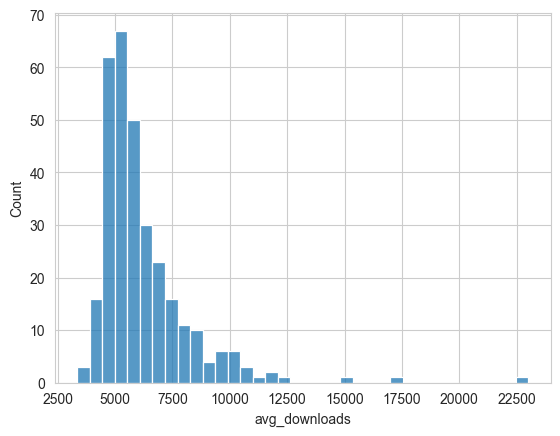

In [18]:
sns.histplot(word_downloads[word_downloads["count"] > 1000]["avg_downloads"])

In [13]:
groups_colors = list(train_colors.groupby("image_id"))
groups_words = list(train_keywords.groupby("image_id"))

In [15]:
len(groups_words)

12197

In [4]:
train_keywords

,image_id,image_classification,classification_keyword,confidence_value
0,d0d041755d,Predicted,grove,99.077
1,d0d041755d,Predicted,compass,26.864
2,d0d041755d,Predicted,field,94.294
3,d0d041755d,Predicted,jar,43.129
4,d0d041755d,Predicted,flower,81.635
...,...,...,...,...
1291027,8aa2cc9225,Predicted,hotel,33.519
1291028,8aa2cc9225,Predicted,resort,28.783
1291029,8aa2cc9225,Predicted,light,52.601
1291030,8aa2cc9225,Predicted,light fixture,33.200


<Axes: xlabel='color_score', ylabel='stats_downloads'>

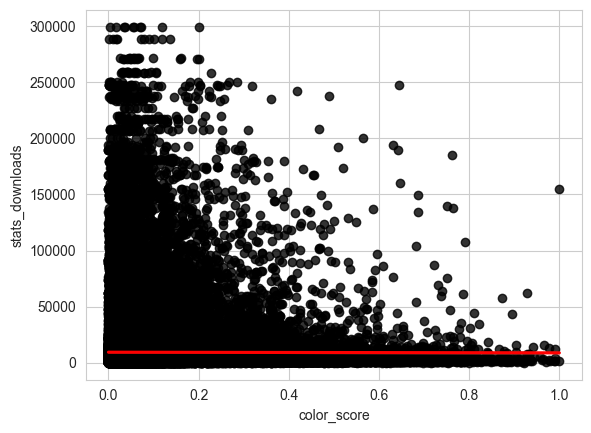

In [64]:
sns.regplot(x="color_score", y="stats_downloads", data=colors_labeled, scatter_kws={"color": "black"}, line_kws={"color": "red"})

<Axes: xlabel='pixel_coverage', ylabel='stats_downloads'>

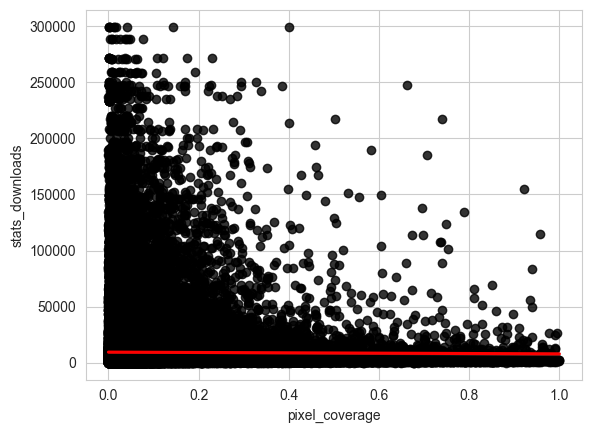

In [65]:
sns.regplot(x="pixel_coverage", y="stats_downloads", data=colors_labeled, scatter_kws={"color": "black"}, line_kws={"color": "red"})

<Axes: ylabel='avg_downloads'>

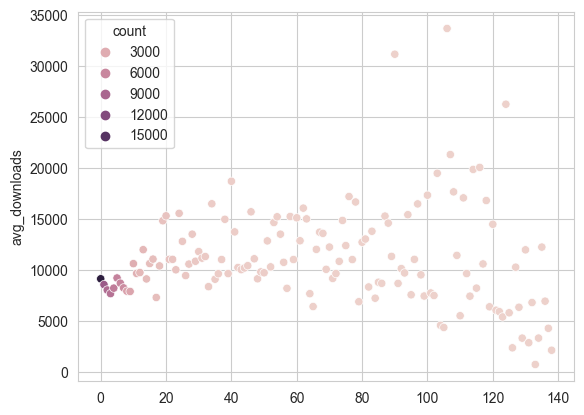

In [63]:
# sns.regplot(x=color_downloads.index, y="avg_downloads", data=color_downloads, 
#             color="count",
#             scatter_kws={"color": "black"}, 
#             line_kws={"color": "red"}
#             )

sns.scatterplot(x=color_downloads.index, y="avg_downloads", data=color_downloads, 
            hue="count",
            )

# XGBoost Testing

In [104]:
# Preprocess train data
cam_make_map = {
 "ASUS": "Asus", "Cannon": "Canon", 
 'Canon, SVR 90mm, 15 images': "Canon",
 'Canon, SVR90, 15 images': "Canon",
 'Canon, SVR90mm, 11 images': "Canon",
 'Canon, WOGT71, 19 images': "Canon",
 'Canon, WOGT71, 26 images': "Canon",
 'Canon, WOGT71, 32 images': "Canon",
 "canon": "Canon",
 'DJI Mavic 2 Pro': "DJI",
 'DJI Mavic Pro': "DJI",
 'DJI Spark': "DJI",
 'FUJIFILM': "Fujifilm",
 'FujiFilm': "Fujifilm",
 'Fujica': "Fujifilm",
 "google": "Google",
 'HASSELBLAD': "Hasselblad",
 "HUAWEI": "Huawei",
 'LEICA CAMERA AG': "LEICA",
 'Leica Camera AG': "LEICA",
 'LG Electronics': "LGE",
 'NIKON': "Nikon",
 'NIKON CORPORATION': "Nikon",
 'OLYMPUS CORPORATION': "Olympus",
 'OLYMPUS IMAGING CORP.': "Olympus",
 'PENTAX Corporation': "Pentax",
 'PENTAX RICOH IMAGING': "Pentax",
 "PENTAX": "Pentax",
 'RICOH IMAGING COMPANY, LTD.': "Ricoh",
 "SAMSUNG": "Samsung",
 "SONY": "Sony",
 "XIAOMI": "Xiaomi",
 'XIAOYI': "Xiaomi",
 'ZWO WOGT71': "ZWO",
 'ZWO w/ WOGT71 21 frames each SHO': "ZWO",
 'ZWO, WOGT71, 15 frames each of H, O, S': "ZWO",
 'motorola': "Motorola",
 "nikon": "Nikon",
 "olympus": "Olympus",
 "samsung": "Samsung",
 "sony": "Sony",
 }

train = train[(train["stats_downloads"] < 400000)]
train["image_category"] = train["image_category"].replace({"Featured": 1, "Not Featured": 0})
train["camera_make"] = train["camera_make"].replace(cam_make_map)
train["camera_make"] = train["camera_make"].apply(lambda x: str(x).lower())
make_counts = train["camera_make"].value_counts()

# Remove instances where camera_make <= 10
# train = train[train["camera_make"].isin(make_counts[make_counts > 10].index)]
train["exposure_time"] = train["exposure_time"].apply(frac_to_float)
# train["photo_submitted_at"] = pd.to_datetime(train["photo_submitted_at"])

# Fill Missing Values
train["aperture_value"] = train["aperture_value"].fillna(train["aperture_value"].mean())
train["iso"] = train["iso"].fillna(train["iso"].mean())
train["exposure_time"] = train["exposure_time"].fillna(train["exposure_time"].mean())

# Fill missing camera_make data based on camera_model data
make_replace_id = ["eca7e87d03", "bee68f9815", "5e15dcf061", "efd3bf77ec", "63cd2598c2", "759de7f18d", "8b215885c7", "c83069821b", "4bdba7914b", "913cc10182"]
make_replace_str = ["olympus", "nikon", "canon", "nikon", "nikon", "nikon", "canon", "sony", "olympus", "olympus"]
for replace_id, replace_str in zip(make_replace_id, make_replace_str):
    train.loc[train["image_id"] == replace_id, "camera_make"] = replace_str

# Drop unnecessary columns
# train.drop(columns=["photo_url", "photo_image_url", "photo_submitted_at", "latitude", "longitude", "country", "city"], inplace=True)

# Drop columns for now
# train.drop(columns=["obs_hour", "obs_min", "obs_sec", "width", "height", "iso", "aperture_value", "focal_length", "exposure_time", "description1", "description2", "camera_model"], inplace=True)

# Day and hour may be important, keep aspect ratio because image dimensions make sense to affect download rates (if image is shaped too tall or wide it could be negative)

train_num = train.select_dtypes(include=np.number)

feature_importance = ['total_days',
 'image_category',
 'exposure_time',
 'height',
 'aspect_ratio',
 'width',
 'iso',
 'obs_sec',
 'focal_length',
 'obs_min',
 'aperture_value',
 'obs_hour']

In [210]:
# train = pd.read_csv("data/train_with_hwc8000.csv")
train

,image_id,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,stats_downloads,high_word_count,high_color_count,high_weighted_word_count,high_weighted_color_count
0,68105c019b,Thursday,15,13,10,1,2592,1728,1.500,Pristine water lily,rule of thirds photography of pink and white l...,canon,Canon EOS 60D,200.000,14.000,50.000,0.017,2361,167503,5,2,8832.250,8907.599
1,06d11c4edd,Wednesday,21,59,51,1,4000,6000,0.670,NaN,sand in desert,sony,ILCE-6500,100.000,2.500,30.000,0.001,1255,1839,9,1,6191.692,9238.795
2,f6599edba1,Tuesday,4,10,11,1,5504,8256,0.670,NaN,green trees near brown mountain during daytime,nikon,NIKON D850,64.000,2.800,48.000,0.001,1138,787,14,1,6538.208,8700.847
3,0f4bcc2d36,Monday,23,46,21,1,3627,2040,1.780,NaN,gray dock aerial photography,dji,FC220,139.000,2.200,4.700,0.010,1579,2049,19,0,6583.103,8754.852
4,74db502ed5,Saturday,11,4,20,1,4896,3264,1.500,NaN,people walking on green grass field near lake ...,fujifilm,X-T10,400.000,6.400,22.200,0.002,1050,2982,21,6,6933.680,10344.245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12123,18eaca644e,Monday,13,7,25,1,4480,6111,0.730,NaN,calm water during night time,canon,Canon EOS 5D Mark IV,100.000,5.600,300.000,0.003,1265,2353,24,3,7111.747,8840.593
12124,eb25cd769e,Monday,20,32,28,1,2403,3337,0.720,NaN,snowflakes on ground,canon,Canon EOS 5D Mark III,400.000,5.000,100.000,0.003,1503,3541,2,0,5829.021,8083.211
12125,73302461d0,Thursday,1,54,16,1,5184,3456,1.500,Inside of the small wave,NaN,canon,Canon EOS M,400.000,4.000,21.000,0.000,2501,14581,14,3,9575.381,13116.181
12126,f2587b2b08,Thursday,18,2,32,1,6000,4000,1.500,Tropical palm,low angle of banana tree,nikon,NIKON D5300,800.000,1.800,50.000,0.003,2508,9247,11,2,8448.478,8647.285


In [220]:
# Split data
data = train.select_dtypes(include=np.number)
X = data.drop(columns=["stats_downloads", "high_word_count", "high_color_count"])
# X = data.drop(columns=["stats_downloads"])
y = data["stats_downloads"]

# X_subset = X[feature_importance[:7] + ["high_word_count"]]

# X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=8)

In [221]:
from sklearn.feature_selection import RFE
estimator = XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=0.5, colsample_bynode=0.5,
                              colsample_bytree=1.0, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=0.0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.06416530723807765, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=np.nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=8, reg_alpha=0.0,
                              reg_lambda=10.0,)
selector = RFE(estimator, n_features_to_select=1, step=1)
selector = selector.fit(X, y)
print(selector.support_)

selector.ranking_
# X.columns[selector.support_]

[False False False False False False False False False False False False
  True False]


array([13,  8, 14,  7, 12,  4,  6,  9, 10, 11,  5,  2,  1,  3])

In [222]:
rfe_rankings = pd.DataFrame({"rank": selector.ranking_, "column": X.columns}).sort_values("rank")
rfe_rankings

,rank,column
12,1,high_weighted_word_count
11,2,total_days
13,3,high_weighted_color_count
5,4,height
10,5,exposure_time
6,6,aspect_ratio
3,7,image_category
1,8,obs_min
7,9,iso
8,10,aperture_value


In [145]:
feature_importance

['total_days',
 'image_category',
 'exposure_time',
 'height',
 'aspect_ratio',
 'width',
 'iso',
 'obs_sec',
 'focal_length',
 'obs_min',
 'aperture_value',
 'obs_hour']

In [146]:
X_subset

,total_days,image_category,exposure_time,height,aspect_ratio,width,iso,high_word_count
0,2361,1,0.017,1728,1.500,2592,200.000,5
1,1255,1,0.001,6000,0.670,4000,100.000,9
2,1138,1,0.001,8256,0.670,5504,64.000,14
3,1579,1,0.010,2040,1.780,3627,139.000,19
4,1050,1,0.002,3264,1.500,4896,400.000,21
...,...,...,...,...,...,...,...,...
12123,1265,1,0.003,6111,0.730,4480,100.000,24
12124,1503,1,0.003,3337,0.720,2403,400.000,2
12125,2501,1,0.000,3456,1.500,5184,400.000,14
12126,2508,1,0.003,4000,1.500,6000,800.000,11


In [227]:
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
# imptr = SimpleImputer(strategy="mean", add_indicator=False)

kf = KFold(n_splits=5)

# X_subset = X[feature_importance[:7]]
# X_subset = X[feature_importance[:7] + ["high_word_count"]]
X_subset = X[rfe_rankings.column[:7]]

xgb = XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=0.5, colsample_bynode=0.5,
                              colsample_bytree=1.0, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=0.0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.06416530723807765, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=np.nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=8, reg_alpha=0.0,
                              reg_lambda=10.0,)

scores = cross_val_score(xgb, X_subset, y, scoring="neg_root_mean_squared_error", cv=kf, n_jobs=1)

print(f"Mean RMSE: {np.mean(scores)}, STD RMSE: {np.std(scores)}")

Mean RMSE: -21431.5870661639, STD RMSE: 947.1366959634249


In [ ]:
Mean RMSE: -21548.00979558584, STD RMSE: 954.6943879323617


In [ ]:
# Best: Mean RMSE: -22123.722021447447, STD RMSE: 850.4901814683802